In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.layers import Dense, Activation, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model, model_from_json
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


In [2]:
def load(fname,test=False, cols=None):
    df = pd.read_csv(fname)
    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if cols:
        df = df[list(cols)+['Image']]
    
    #print( df.count())
    df = df.dropna()
    columns = df.columns
    
    X = np.vstack(df['Image'].values)#/255
    X = X.astype(np.float32)
    
    if not test:
        y = df[df.columns[:-1]].values
        #y = (y-48)/48
        X, y = shuffle(X, y, random_state=20)
        y = y.astype(np.float32)
    else:
        y = None
        columns = None
    
    return X, y, columns

def load2d(fname,test=False, cols=None):
    
    X, y, columns = load(fname,test, cols)
    X = X.reshape(-1,96,96, 1)
    
    return X, y, columns


    

In [3]:
X, y, columns = load2d("data/training.csv",test=False)
columns = np.array(list(columns[:-1]))
columns

array(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y',
       'mouth_right_corner_x', 'mouth_right_corner_y',
       'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'],
      dtype='<U25')

In [4]:
y

array([[65.16754 , 35.4048  , 31.82537 , ..., 68.74642 , 48.251247,
        78.30802 ],
       [65.0355  , 37.43655 , 30.51225 , ..., 70.284   , 48.27675 ,
        80.67525 ],
       [65.628586, 37.107445, 31.065538, ..., 76.12108 , 51.421314,
        78.60107 ],
       ...,
       [62.77147 , 37.632923, 30.480501, ..., 82.81032 , 51.890133,
        85.50015 ],
       [67.769035, 32.55329 , 26.036516, ..., 70.97032 , 50.02297 ,
        88.52129 ],
       [63.779495, 35.531296, 29.167866, ..., 60.407394, 46.834286,
        75.18978 ]], dtype=float32)

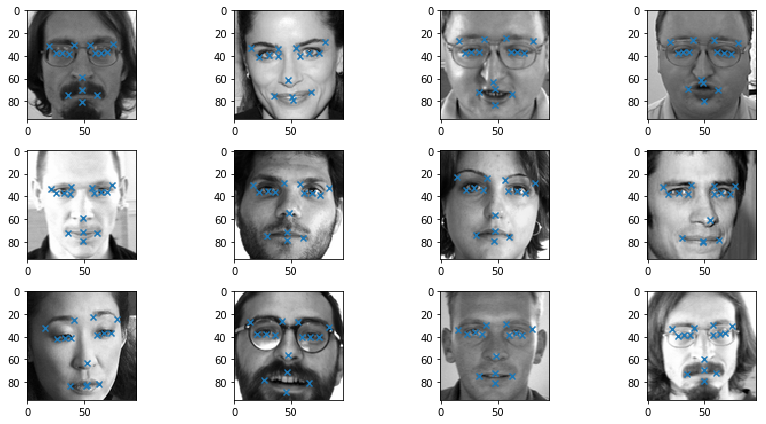

In [5]:
import seaborn as sns
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(X[i, :, :, 0], cmap="gray")
    plt.scatter(y[i, range(0, 30, 2)], y[i, range(1, 30, 2)], marker='x')

plt.tight_layout()
plt.show()

In [6]:
X_test, _, __ = load2d("data/test.csv",test=True)
X_test.shape

(1783, 96, 96, 1)

In [7]:
model = Sequential()

model.add(BatchNormalization(input_shape=(96, 96, 1)))
model.add(Conv2D(24, 5, data_format="channels_last", kernel_initializer="he_normal", 
                 input_shape=(96, 96, 1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(36, 5))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(48, 5))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(64, 3))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))

model.add(Dense(90))
model.add(Activation("relu"))

model.add(Dense(30))
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 24)        624       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 24)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 36)        21636     
_________________________________________________________________
activation_2 (Activation)    (None, 44, 44, 36)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 36)        0         
__________

In [8]:
# save best weights
checkpointer = ModelCheckpoint(filepath='face_model.h5', verbose=1, save_best_only=True)

# num epochs
epochs = 50

# run model
hist = model.fit(X, y, epochs=epochs, 
                 validation_split=0.2, callbacks=[checkpointer], verbose=2)

# save model to json
model_json = model.to_json()
with open("face_model.json", "w") as json_file:
    json_file.write(model_json)

Train on 1712 samples, validate on 428 samples
Epoch 1/50
 - 40s - loss: 548.3480 - acc: 0.3849 - val_loss: 206.5669 - val_acc: 0.7033

Epoch 00001: val_loss improved from inf to 206.56691, saving model to face_model.h5
Epoch 2/50
 - 35s - loss: 269.9727 - acc: 0.6256 - val_loss: 117.4652 - val_acc: 0.7079

Epoch 00002: val_loss improved from 206.56691 to 117.46521, saving model to face_model.h5
Epoch 3/50


KeyboardInterrupt: 

In [ ]:
model.load_weights("face_model.h5")
y_test = model.predict(X_test)
print(y_test.shape)

In [ ]:
id_lookup_frame = pd.read_csv("IdLookupTable.csv")
val_reqrd = id_lookup_frame[["ImageId", "FeatureName"]]
val_reqrd.head()

In [ ]:
y_res = []
j = 0
k = 0
m = 0
for i in range(1, 1784):
    img = np.array(val_reqrd[val_reqrd["ImageId"]==i])
    if img.shape[0] == 30:
        y_res += list(y_test[i-1,:])
        j += 30
    else:
        slice_img = y_test[i-1, :]
        y_res += [slice_img[j] for j in range(30) if columns[j] in img[:, 1]]
        k += len([slice_img[j] for j in range(30) if columns[j] in img[:, 1]])
y_res = np.array(y_res)
y_res.shape

In [ ]:
result_dict = {
    "RowId": range(1,27125),
    "Location": y_res%96
}
result_df = pd.DataFrame(result_dict, )
result_df.to_csv("result.csv", index=False, columns=["RowId", "Location"])